DEBUG: path entered = C:\Users\hp\Downloads\archive (6)\bank.csv
Loaded dataset with 11162 rows and 17 columns.
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

Select quasi-identifiers (comma-separated):
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

Select sensitive column:

Select target column for Membership Inference (binary or multi-class):

Using QIs: ['age', 'job', 'marital', 'education', 'contact', 'month', 'day']
Sensitive column: deposit
Target column (MIA): deposit
MIA Classification Report:
               precision    recall  f1-score   support

          no       0.83      0.84      0.84      2937
         yes       0.82      0.81      0.82      2644

    accuracy                           0.83      558

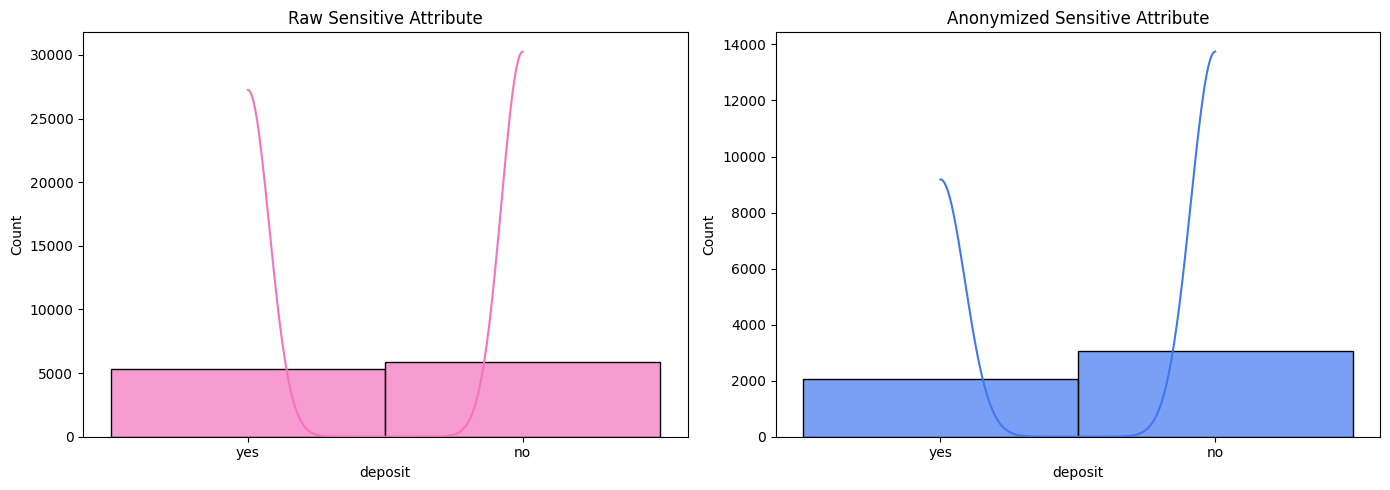

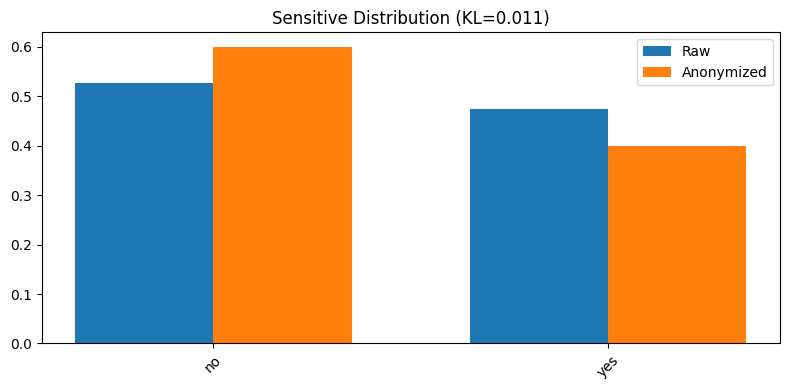

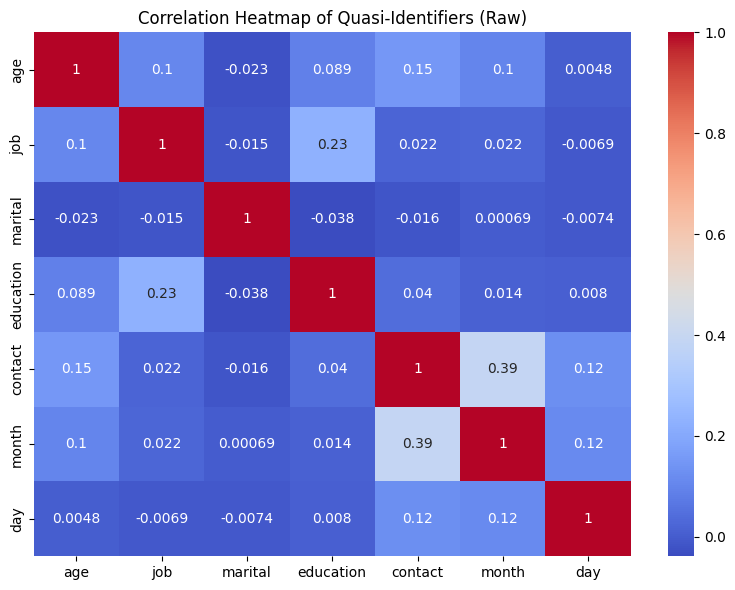

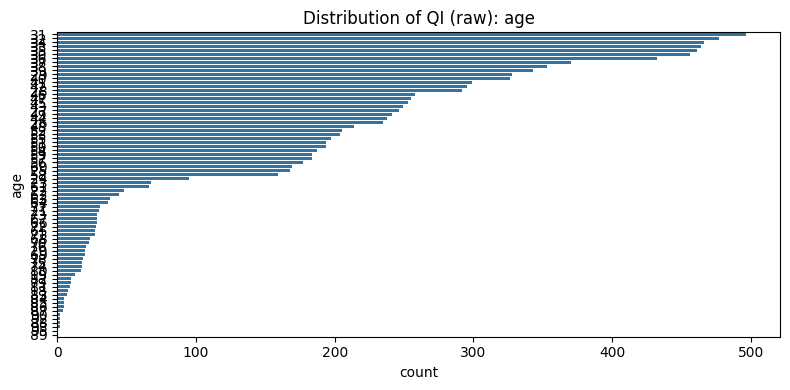

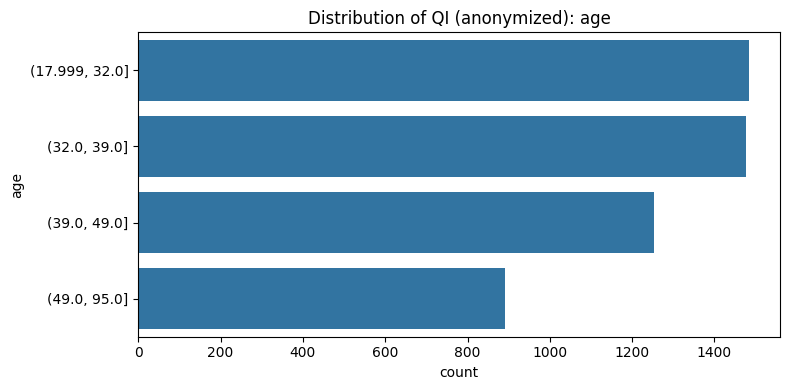

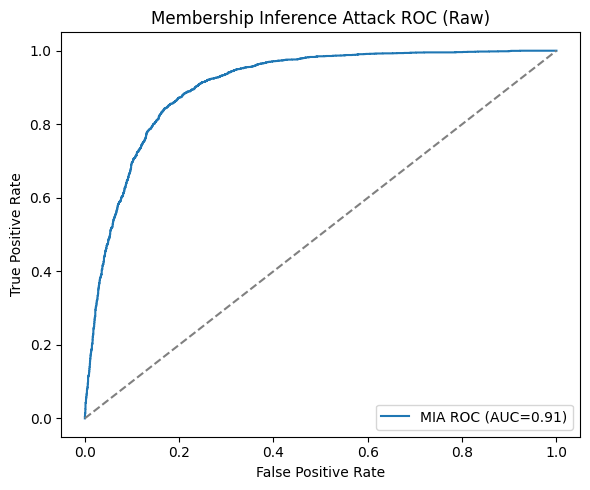

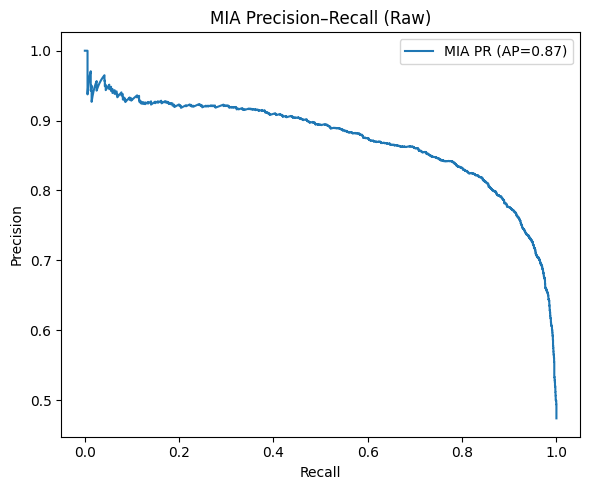

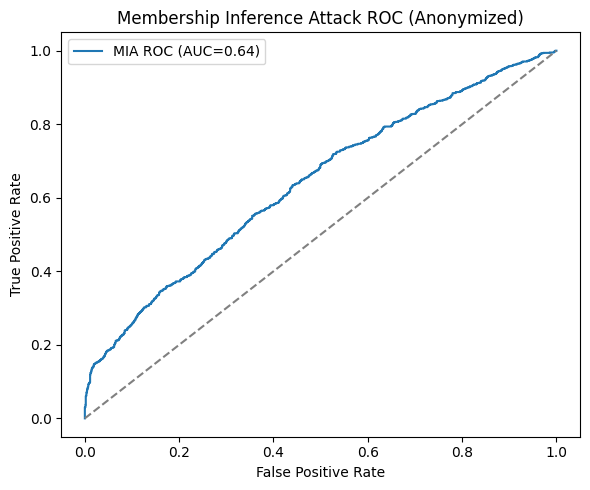

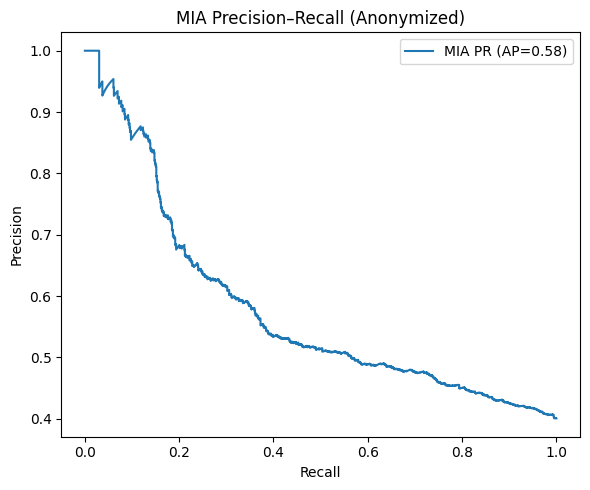

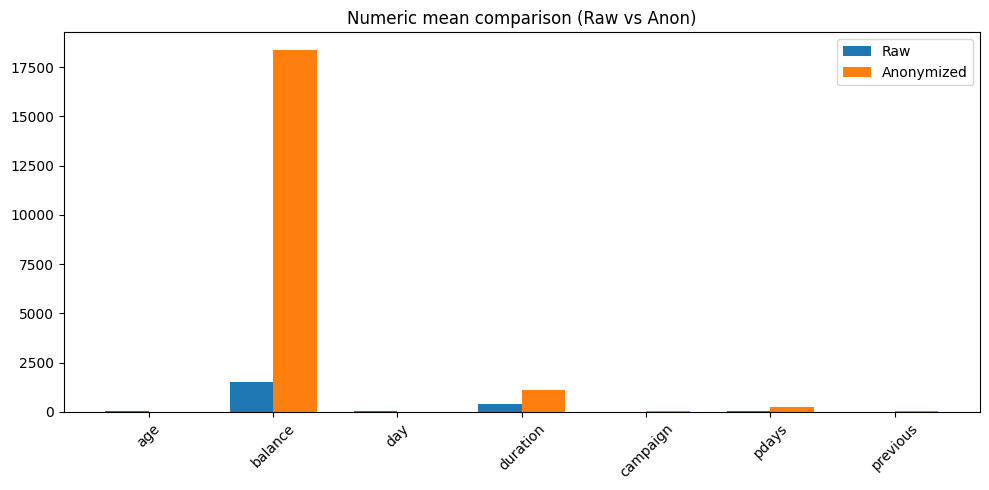

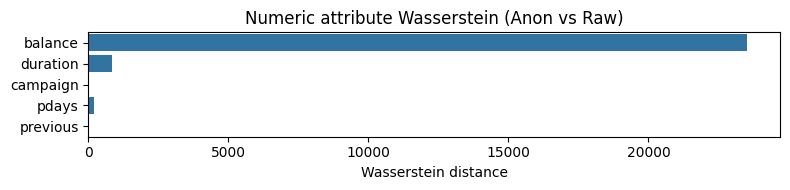

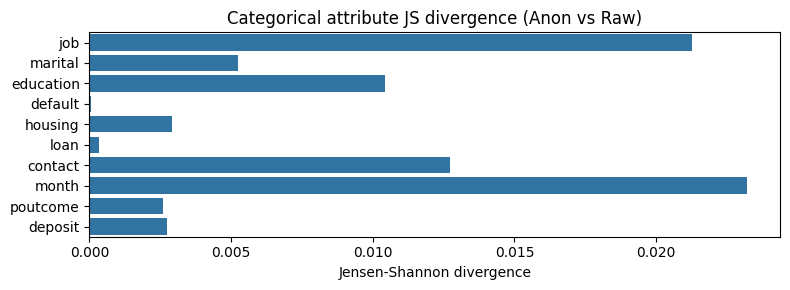


Saved plots to directory: results/plots
MIA Classification Report:
               precision    recall  f1-score   support

          no       0.71      0.74      0.72      1671
         yes       0.60      0.57      0.59      1168

    accuracy                           0.67      2839
   macro avg       0.66      0.65      0.66      2839
weighted avg       0.67      0.67      0.67      2839

Attribute Inference Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71       836
           1       0.58      0.56      0.57       584

    accuracy                           0.65      1420
   macro avg       0.64      0.64      0.64      1420
weighted avg       0.65      0.65      0.65      1420

MIA Classification Report:
               precision    recall  f1-score   support

          no       0.67      0.67      0.67      1671
         yes       0.53      0.54      0.54      1168

    accuracy                           0.

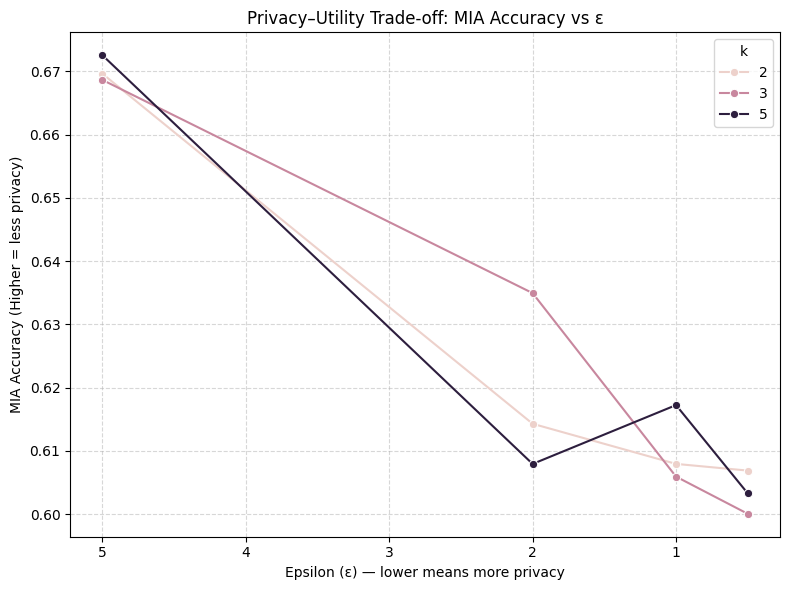

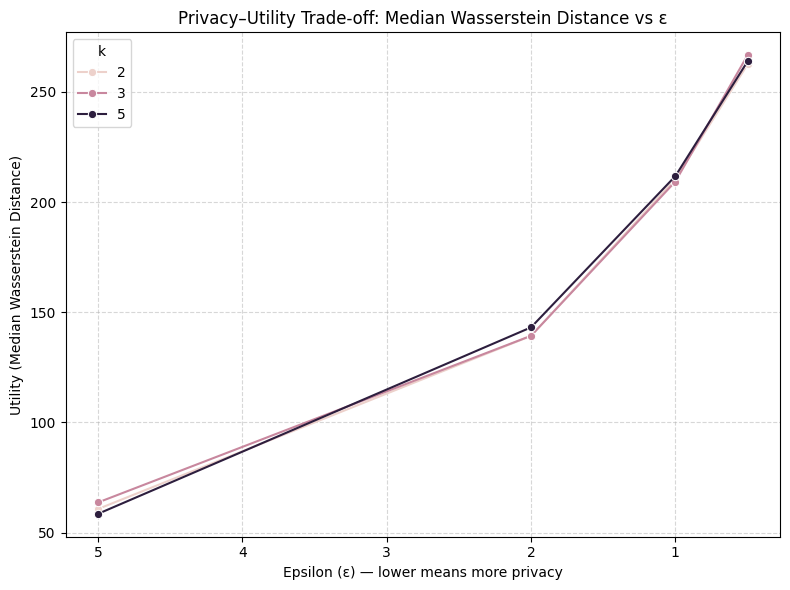


Saved anonymized dataset to: anonymized_dataset.csv

=== AI Adversarial Privacy Auditor Results ===
Raw Overall Risk (0-100): 68.21
Anonymized Overall Risk (0-100): 18.38
Unique records (raw): 9938
Unique records (anon): 0
Prop eq. classes with k<5 (raw): 0.9985665651316968
Prop eq. classes with k<5 (anon): 0.2418723070896984
MIA accuracy (raw): 0.8301379681060742
MIA accuracy (anon): 0.5985115550332941
Attr AUC (raw): 0.901707399210512
Attr AUC (anon): 0.6309570646814469

=== AI Adversarial Privacy Auditor (Extended) ===
Raw Overall Risk      : 68.21
Anon Overall Risk     : 18.38
Synth (MIA acc)       : 0.511
MIA acc (raw/anon)    : 0.830 / 0.599
AIA AUC (raw/anon)    : 0.902 / 0.631
Prop k<5 (raw/anon)   : 0.999 / 0.242
DP (ε for example col): 1.0 (scale≈73500.000)
Utility(Anon) medians: {'num_mean_delta_med': 212.1150395612759, 'num_wass_med': 212.16216373257132, 'cat_JS_med': 0.0040881362134233285}
Utility(Synth) medians: {'num_mean_delta_med': 0.5639998282710874, 'num_wass_med': 

In [ ]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy, wasserstein_distance
from sklearn.model_selection import train_test_split


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# -------------------------------
# 1) Load any dataset
# -------------------------------
def load_dataset():
    path = input("Enter dataset path (CSV/XLSX): ").strip()
    path = path.strip('"').strip("'")  # Remove any quotes
    print("DEBUG: path entered =", path)
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith(".xlsx"):
        df = pd.read_excel(path)
    else:
        raise ValueError("Unsupported file format.")
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
    print("Columns:", list(df.columns))
    return df
raw_df = load_dataset()


# -------------------------------
# 2) User selects QIs and sensitive column
# -------------------------------
print("\nSelect quasi-identifiers (comma-separated):")
print("Columns:", list(raw_df.columns))
qis = [q.strip() for q in input("QIs: ").strip().split(",")]
qis = [q for q in qis if q in raw_df.columns]


print("\nSelect sensitive column:")
sensitive_col = input("Sensitive column: ").strip()
if sensitive_col not in raw_df.columns:
    raise ValueError("Sensitive column not found.")


print("\nSelect target column for Membership Inference (binary or multi-class):")
target_col = input("Target column: ").strip()
if target_col not in raw_df.columns:
    raise ValueError("Target column not found.")


print(f"\nUsing QIs: {qis}")
print(f"Sensitive column: {sensitive_col}")
print(f"Target column (MIA): {target_col}")


# -------------------------------
# 3) Clean + detect QI types
# -------------------------------
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()


    # Treat text-like IDs as strings
    text_like = ["email", "mail", "id", "roll", "contact", "phone", "mobile"]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str).fillna("missing")
        elif any(key in col.lower() for key in text_like):
            df[col] = df[col].astype(str).fillna("missing")


    # Keep numeric numerics
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]) or pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors="coerce")


    return df


raw_df = clean_dataframe(raw_df)


cat_qis = [q for q in qis if raw_df[q].dtype == "object" or raw_df[q].nunique() < 20]
num_qis = [q for q in qis if q not in cat_qis]


# -------------------------------
# 4) Generalize QIs
# -------------------------------
def generalize_qis(df, num_qis, cat_qis):
    gen_df = df.copy()


    # Numeric QIs → bucketize into quartiles; fallback to string if needed
    for col in num_qis:
        try:
            gen_df[col] = pd.qcut(gen_df[col], q=4, duplicates='drop').astype(str)
        except Exception:
            gen_df[col] = gen_df[col].astype(str)


    # Categorical QIs → string & mask rare categories
    for col in cat_qis:
        s = gen_df[col].astype(str)
        freq = s.value_counts()
        rare = freq[freq < 5].index
        gen_df[col] = s.replace(rare, "Other")


    return gen_df


# -------------------------------
# 5) k-Anonymity
# -------------------------------
def apply_k_anonymity(df, qis, k=3):
    if len(qis) == 0:
        return df.copy()


    num_local = [c for c in qis if pd.api.types.is_numeric_dtype(df[c])]
    cat_local = [c for c in qis if not pd.api.types.is_numeric_dtype(df[c])]


    anon = generalize_qis(df, num_local, cat_local)
    # Create in-frame key to avoid 1-D grouper issues
    anon = anon.copy()
    anon["QIKey"] = anon[qis].astype(str).agg("|".join, axis=1)


    sizes = anon.groupby("QIKey").size()
    keep_keys = sizes[sizes >= k].index
    out = anon[anon["QIKey"].isin(keep_keys)].drop(columns=["QIKey"]).reset_index(drop=True)
    return out


# -------------------------------
# 6) l-Diversity
# -------------------------------
def enforce_l_diversity(df, qis, sensitive_col, l=2):
    if df.empty or len(qis) == 0:
        return df.copy()


    safe_df = df.copy()
    safe_df["QIKey"] = safe_df[qis].astype(str).agg("|".join, axis=1)


    div = safe_df.groupby("QIKey")[sensitive_col].nunique()
    keep = div[div >= l].index
    out = safe_df[safe_df["QIKey"].isin(keep)].drop(columns=["QIKey"]).reset_index(drop=True)
    return out


# -------------------------------
# 7) t-Closeness (Total Variation Distance)
# -------------------------------
def enforce_t_closeness(df, qis, sensitive_col, t=0.2):
    if df.empty or len(qis) == 0:
        return df.copy()


    safe_df = df.copy()
    safe_df["QIKey"] = safe_df[qis].astype(str).agg("|".join, axis=1)


    global_dist = safe_df[sensitive_col].value_counts(normalize=True)


    bad_keys = []
    for key_val, grp in safe_df.groupby("QIKey"):
        loc = grp[sensitive_col].value_counts(normalize=True)
        # align indices
        loc = loc.reindex(global_dist.index, fill_value=0)
        tvd = 0.5 * (global_dist - loc).abs().sum()
        if tvd > t:
            bad_keys.append(key_val)


    out = safe_df[~safe_df["QIKey"].isin(bad_keys)].drop(columns=["QIKey"]).reset_index(drop=True)
    return out


# -------------------------------
# 8) Laplace noise for numeric columns
# -------------------------------
def add_laplace_noise(df, eps=1.0, numeric_cols=None):
    """
    Adds Laplace noise per numeric column with sensitivity estimated as range.
    Smaller eps => stronger privacy (more noise). Returns anon, meta.
    """
    anon = df.copy()
    meta = {}
    if numeric_cols is None:
        numeric_cols = [c for c in anon.columns if pd.api.types.is_numeric_dtype(anon[c])]
    if len(numeric_cols) == 0:
        return anon, meta


    eps = max(float(eps), 1e-6)
    for c in numeric_cols:
        col = pd.to_numeric(anon[c], errors="coerce")
        # Convert boolean columns to float to avoid TypeError
        if pd.api.types.is_bool_dtype(anon[c]):
            col = col.astype(float)
        if col.notna().sum() == 0:
            continue
        vmin, vmax = np.nanmin(col), np.nanmax(col)
        sens = max(float(vmax - vmin), 1.0)
        scale = sens / eps
        noise = np.random.laplace(0.0, scale, size=len(col))
        noised = (col.fillna(np.nanmedian(col)) + noise)
        # (optional) clip to plausible range
        anon[c] = np.clip(noised, vmin, vmax)
        meta[c] = {"eps": eps, "sensitivity": sens, "scale": scale}
    return anon, meta
# -------------------------------
# 9) Risk metrics
# -------------------------------
def k_anonymity_risk(df, qis):
    if df.empty or len(qis) == 0:
        return {
            "unique_records": 0,
            "prop_k<5_records": 0.0,
            "avg_eq_class_size": 0.0,
            "median_eq_class_size": 0.0,
            "eq_class_sizes": []
        }
    key = df[qis].astype(str).agg("|".join, axis=1)
    counts = key.value_counts()
    k1 = int((counts == 1).sum())
    prop_small = float(counts[counts < 5].sum() / max(len(df), 1))
    return {
        "unique_records": k1,
        "prop_k<5_records": prop_small,
        "avg_eq_class_size": float(counts.mean()),
        "median_eq_class_size": float(counts.median()),
        "eq_class_sizes": counts.tolist()
    }


MAX_ROWS = 20000
if raw_df.shape[0] > MAX_ROWS:
    print(f"Sampling down to {MAX_ROWS} rows for memory safety.")
    raw_df = raw_df.sample(n=MAX_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)


def build_preprocessor(df, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=drop_cols, errors="ignore").copy()
    num_cols = [c for c in X.columns if X[c].dtype != "object"]
    # Only one-hot encode categorical columns with <30 unique values
    cat_cols = [c for c in X.columns if X[c].dtype == "object" and X[c].nunique() < 30]
    # For high-cardinality columns, use LabelEncoder
    high_card_cols = [c for c in X.columns if X[c].dtype == "object" and X[c].nunique() >= 30]
    for col in high_card_cols:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))


    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)


    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=False), num_cols),
            ("cat", ohe, cat_cols)
        ],
        remainder="drop"
    )
    return pre




# -------------------------------
# 10) Attacks
# -------------------------------
def membership_inference_attack(df, target_col):
    feat_cols = [c for c in df.columns if c != target_col]
    if len(feat_cols) == 0:
        return {"mia_accuracy": 0.0, "binary": False}, None, {}


    X = df[feat_cols]
    y_raw = df[target_col].values


    le = LabelEncoder()
    y = le.fit_transform(y_raw)


    # If only a single class, skip
    if len(np.unique(y)) < 2:
        print(f"Warning: Only one class present in {target_col}. Skipping membership inference attack.")
        return {"mia_accuracy": 0.0, "binary": False}, None, {}


    class_counts = Counter(y)
    stratify = y if min(class_counts.values()) >= 2 else None


    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.5, random_state=7, stratify=stratify
    )


    pre = build_preprocessor(X_tr)
    clf = LogisticRegression(
    max_iter=2000,            # more room to converge
    solver="lbfgs",
    n_jobs=None,
    class_weight="balanced"   # helps with label imbalance (seen in your runs)
)
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_tr, y_tr)


    preds = pipe.predict(X_te)
    acc = accuracy_score(y_te, preds)


    try:
        proba = pipe.predict_proba(X_te)[:, 1] if len(le.classes_) == 2 else None
    except Exception:
        proba = None


    present_labels = np.unique(y_te)
    present_names = le.classes_[present_labels]
    print("MIA Classification Report:\n", classification_report(y_te, preds, labels=present_labels, target_names=[str(x) for x in present_names]))
    artifacts = {
        "X_te": X_te,
        "y_te": y_te,
        "preds": preds,
        "proba": proba,
        "binary": bool(len(le.classes_) == 2)
    }
    return {"mia_accuracy": float(acc), "binary": artifacts["binary"]}, pipe, artifacts


def attribute_inference_attack(df, sensitive_col):
    feat_cols = [c for c in df.columns if c != sensitive_col]
    if len(feat_cols) == 0:
        return {"attack_auc": 0.0, "attack_acc": 0.0, "baseline_acc": 0.0}, None, {}


    X = df[feat_cols]
    y_raw = df[sensitive_col].values


    le = LabelEncoder()
    y = le.fit_transform(y_raw)


    class_counts = Counter(y)
    stratify = y if min(class_counts.values()) >= 2 else None


    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=13, stratify=stratify)
    pre = build_preprocessor(X_tr)
    clf = LogisticRegression(
    max_iter=2000,            # more room to converge
    solver="lbfgs",
    n_jobs=None,
    class_weight="balanced"   # helps with label imbalance (seen in your runs)
)
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_tr, y_tr)


    if len(np.unique(y)) == 2:
        proba = pipe.predict_proba(X_te)[:, 1]
        _auc = roc_auc_score(y_te, proba)
    else:
        proba = None
        _auc = 0.5  # multiclass fallback for AUC


    preds = pipe.predict(X_te)
    acc = accuracy_score(y_te, preds)
    baseline = max(np.mean(y_te == y_te[0]), 1 - np.mean(y_te == y_te[0]))  # trivial baseline approx.


    present_labels = np.unique(y_te)
    print("Attribute Inference Classification Report:\n", classification_report(y_te, preds, labels=present_labels))


    artifacts = {"X_te": X_te, "y_te": y_te, "preds": preds, "proba": proba, "binary": bool(len(np.unique(y)) == 2)}
    return {
        "attack_auc": float(_auc),
        "attack_acc": float(acc),
        "baseline_acc": float(baseline)
    }, pipe, artifacts


# -------------------------------
# 11) Overall score
# -------------------------------
def overall_risk_score(mia_auc, attr_auc, attr_acc_minus_base, prop_small_eq, weights=(0.35, 0.30, 0.20, 0.15)):
    mia_norm = max(0.0, (mia_auc - 0.5) / 0.5)
    attr_norm = max(0.0, (attr_auc - 0.5) / 0.5)
    attr_imp = max(0.0, attr_acc_minus_base)
    w1, w2, w3, w4 = weights
    score01 = w1 * mia_norm + w2 * attr_norm + w3 * attr_imp + w4 * prop_small_eq
    return float(round(score01 * 100, 2))


def utility_report(raw, other, id_cols=None):
    """
    Compare basic utility between two tables with same schema.
    Returns dict of numeric mean/var deltas, categorical JS divergence, etc.
    """
    rep = {"numeric": {}, "categorical": {}}
    numeric_cols = [c for c in raw.columns if pd.api.types.is_numeric_dtype(raw[c])]
    cat_cols = [c for c in raw.columns if not pd.api.types.is_numeric_dtype(raw[c])]


    # Numerics: mean & variance deltas, Wasserstein distance
    for c in numeric_cols:
        r = pd.to_numeric(raw[c], errors="coerce")
        o = pd.to_numeric(other[c], errors="coerce")
        r, o = r.dropna(), o.dropna()
        if len(r) == 0 or len(o) == 0:
            continue
        rep["numeric"][c] = {
            "mean_delta": float(abs(r.mean() - o.mean())),
            "var_delta": float(abs(r.var(ddof=0) - o.var(ddof=0))),
            "wasserstein": float(wasserstein_distance(r, o))
        }


    # Categoricals: Jensen–Shannon divergence of distributions
    def js_div(p, q):
        # p, q as normalized arrays on same support
        m = 0.5*(p+q)
        def kl(a,b):
            a = np.clip(a, 1e-12, 1)
            b = np.clip(b, 1e-12, 1)
            return np.sum(a*np.log(a/b))
        return 0.5*kl(p,m)+0.5*kl(q,m)


    for c in cat_cols:
        r = raw[c].astype(str)
        o = other[c].astype(str)
        sup = sorted(set(r.unique()) | set(o.unique()))
        pr = r.value_counts(normalize=True).reindex(sup).fillna(0).values
        po = o.value_counts(normalize=True).reindex(sup).fillna(0).values
        rep["categorical"][c] = {"JS_divergence": float(js_div(pr, po))}
    return rep


# -------------------------------
# 12) Run audit
# -------------------------------
def run_audit(df, qis, sensitive_col, target_col):
    # --- RAW ---
    mia_metrics, mia_pipe, mia_art = membership_inference_attack(df, target_col=target_col)
    attr_metrics, attr_pipe, attr_art = attribute_inference_attack(df, sensitive_col=sensitive_col)
    kanon_metrics = k_anonymity_risk(df, qis=qis)


    base_score = overall_risk_score(
        mia_auc=0.5 + (mia_metrics["mia_accuracy"] - 0.5),
        attr_auc=attr_metrics["attack_auc"],
        attr_acc_minus_base=attr_metrics["attack_acc"] - attr_metrics["baseline_acc"],
        prop_small_eq=kanon_metrics["prop_k<5_records"]
    )


    # --- DEFENSES ---
    d1 = apply_k_anonymity(df, qis=qis, k=3)
    d2 = enforce_l_diversity(d1, qis=qis, sensitive_col=sensitive_col, l=2)
    d3 = enforce_t_closeness(d2, qis=qis, sensitive_col=sensitive_col, t=0.4)
    anon_df, dp_meta = add_laplace_noise(d3, eps=1.0)


    # --- Anonymized evaluation ---
    if anon_df.empty:
        mia_metrics_an = {"mia_accuracy": 0.0, "binary": False}
        attr_metrics_an = {"attack_auc": 0.5, "attack_acc": 0.0, "baseline_acc": 0.0}
        kanon_metrics_an = {"unique_records": 0, "prop_k<5_records": 0.0,
                            "avg_eq_class_size": 0.0, "median_eq_class_size": 0.0,
                            "eq_class_sizes": []}
        anon_score = 0.0
        mia_art_an = {}
    else:
        mia_metrics_an, _, mia_art_an = membership_inference_attack(anon_df, target_col=target_col)
        attr_metrics_an, _, _ = attribute_inference_attack(anon_df, sensitive_col=sensitive_col)
        kanon_metrics_an = k_anonymity_risk(anon_df, qis=qis)


        anon_score = overall_risk_score(
            mia_auc=0.5 + (mia_metrics_an["mia_accuracy"] - 0.5),
            attr_auc=attr_metrics_an["attack_auc"],
            attr_acc_minus_base=attr_metrics_an["attack_acc"] - attr_metrics_an["baseline_acc"],
            prop_small_eq=kanon_metrics_an["prop_k<5_records"]
        )


        # --- Synthetic evaluation ---
    syn_df = synthesize_tabular(df, n=len(df))
    if syn_df.empty:
        syn_mia = {"mia_accuracy": 0.0, "binary": False}
        syn_attr = {"attack_auc": 0.5, "attack_acc": 0.0, "baseline_acc": 0.0}
        syn_kanon = {"unique_records": 0, "prop_k<5_records": 0.0,
                     "avg_eq_class_size": 0.0, "median_eq_class_size": 0.0,
                     "eq_class_sizes": []}
    else:
        syn_mia, _, _  = membership_inference_attack(syn_df, target_col=target_col)
        syn_attr, _, _ = attribute_inference_attack(syn_df, sensitive_col=sensitive_col)
        syn_kanon = k_anonymity_risk(syn_df, qis=qis)


    util_anon = utility_report(df, anon_df) if not anon_df.empty else {}
    util_syn  = utility_report(df, syn_df)  if not syn_df.empty  else {}


    return {
        # raw
        "raw_mia": mia_metrics,
        "raw_attr": attr_metrics,
        "raw_kanon": kanon_metrics,
        "raw_overall_risk_0_100": base_score,


        # anonymized
        "anon_mia": mia_metrics_an,
        "anon_attr": attr_metrics_an,
        "anon_kanon": kanon_metrics_an,
        "anon_overall_risk_0_100": anon_score,
        "anonymized_df": anon_df,
        "mia_artifacts_raw": mia_art,
        "mia_artifacts_anon": mia_art_an,
        "dp_meta": dp_meta,
        "utility_anon": util_anon,


        # synthetic
        "synth_mia": syn_mia,
        "synth_attr": syn_attr,
        "synth_kanon": syn_kanon,
        "synthetic_df": syn_df,
        "utility_syn": util_syn,
    }


def synthesize_tabular(df, n=None, seed=RANDOM_STATE):
    """
    Lightweight synthetic generator (no external libs):
    - Categorical: sample from empirical distribution
    - Numeric: sample from N(mean, std) then clip to [min, max]
    Preserves marginals (not multivariate correlations).
    """
    rng = np.random.default_rng(seed)
    n = n or len(df)
    syn = {}


    for c in df.columns:
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            vals = s.dropna().astype(float)
            if len(vals) == 0:
                syn[c] = pd.Series([np.nan]*n)
                continue
            mu, sd = float(vals.mean()), float(vals.std(ddof=0) or 1e-6)
            vmin, vmax = float(vals.min()), float(vals.max())
            draw = rng.normal(mu, sd, size=n)
            syn[c] = np.clip(draw, vmin, vmax)
        else:
            s = s.astype(str)
            probs = s.value_counts(normalize=True)
            syn[c] = rng.choice(probs.index.to_numpy(), p=probs.values, size=n)


    return pd.DataFrame(syn)


results = run_audit(raw_df, qis, sensitive_col, target_col)


def print_summary(results):
    print("\n=== AI Adversarial Privacy Auditor (Extended) ===")
    print(f"Raw Overall Risk      : {results['raw_overall_risk_0_100']:.2f}")
    print(f"Anon Overall Risk     : {results['anon_overall_risk_0_100']:.2f}")
    if "synth_mia" in results:
        print(f"Synth (MIA acc)       : {results['synth_mia']['mia_accuracy']:.3f}")
    print(f"MIA acc (raw/anon)    : {results['raw_mia']['mia_accuracy']:.3f} / {results['anon_mia']['mia_accuracy']:.3f}")
    print(f"AIA AUC (raw/anon)    : {results['raw_attr']['attack_auc']:.3f} / {results['anon_attr']['attack_auc']:.3f}")
    print(f"Prop k<5 (raw/anon)   : {results['raw_kanon']['prop_k<5_records']:.3f} / {results['anon_kanon']['prop_k<5_records']:.3f}")
    if 'dp_meta' in results and results['dp_meta']:
        any_col = next(iter(results['dp_meta']))
        print(f"DP (ε for example col): {results['dp_meta'][any_col]['eps']} (scale≈{results['dp_meta'][any_col]['scale']:.3f})")


    # Utility quick view (median across columns)
    def summarize_utility(util):
        if not util: return {}
        num = util.get("numeric", {})
        cat = util.get("categorical", {})
        md = lambda arr: float(np.median(arr)) if len(arr) else 0.0
        out = {}
        if num:
            out["num_mean_delta_med"] = md([v["mean_delta"] for v in num.values()])
            out["num_wass_med"] = md([v["wasserstein"] for v in num.values()])
        if cat:
            out["cat_JS_med"] = md([v["JS_divergence"] for v in cat.values()])
        return out


    ua = summarize_utility(results.get("utility_anon", {}))
    us = summarize_utility(results.get("utility_syn", {}))
    if ua: print("Utility(Anon) medians:", ua)
    if us: print("Utility(Synth) medians:", us)




# -------------------------------
# 13) Visualizations (safe & optional)
# -------------------------------
def visualize_privacy(raw_df, results, qis, sensitive_col, save_dir="results/plots"):
    os.makedirs(save_dir, exist_ok=True)

    # 1 & 2: Raw vs Anonymized sensitive distribution (hist + kde)
    if sensitive_col in raw_df.columns and not results["anonymized_df"].empty:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        sns.histplot(raw_df[sensitive_col], kde=True, ax=ax[0], alpha=0.7, color="#f572be")
        ax[0].set_title("Raw Sensitive Attribute")
        sns.histplot(results["anonymized_df"][sensitive_col], kde=True, ax=ax[1], alpha=0.7, color="#4078f0")
        ax[1].set_title("Anonymized Sensitive Attribute")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/sensitive_distribution.png")
        plt.show()

        # KL divergence bar plot
        p = raw_df[sensitive_col].value_counts(normalize=True).sort_index()
        q = results["anonymized_df"][sensitive_col].value_counts(normalize=True).reindex(p.index).fillna(0)
        kl_div = entropy(p, q)
        plt.figure(figsize=(8, 4))
        width = 0.35
        idx = np.arange(len(p))
        plt.bar(idx - width/2, p.values, width=width, label="Raw",)
        plt.bar(idx + width/2, q.values, width=width, label="Anonymized")
        plt.xticks(idx, [str(x) for x in p.index], rotation=45)
        plt.title(f"Sensitive Distribution (KL={kl_div:.3f})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{save_dir}/sensitive_distribution_kl.png")
        plt.show()

    # 3: Correlation heatmap of QIs (factorized)
    if qis:
        corr_df = raw_df[qis].apply(lambda x: pd.factorize(x)[0])
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
        plt.title("Correlation Heatmap of Quasi-Identifiers (Raw)")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/qi_correlation_heatmap.png")
        plt.show()

    # 4: QI counts (first QI) - countplot
    if qis:
        qi_to_plot = qis[0]
        plt.figure(figsize=(8, 4))
        sns.countplot(y=raw_df[qi_to_plot].astype(str), order=raw_df[qi_to_plot].value_counts().index)
        plt.title(f"Distribution of QI (raw): {qi_to_plot}")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/qi_distribution_raw_{qi_to_plot}.png")
        plt.show()

        if not results["anonymized_df"].empty and qi_to_plot in results["anonymized_df"].columns:
            plt.figure(figsize=(8, 4))
            sns.countplot(y=results["anonymized_df"][qi_to_plot].astype(str), order=results["anonymized_df"][qi_to_plot].value_counts().index)
            plt.title(f"Distribution of QI (anonymized): {qi_to_plot}")
            plt.tight_layout()
            plt.savefig(f"{save_dir}/qi_distribution_anon_{qi_to_plot}.png")
            plt.show()

    # 5 & 6: MIA ROC & PR (raw) if available
    mia_art = results.get("mia_artifacts_raw", {})
    if mia_art and mia_art.get("binary") and mia_art.get("proba") is not None:
        y_te = mia_art["y_te"]; y_probs = mia_art["proba"]
        fpr, tpr, _ = roc_curve(y_te, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"MIA ROC (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], '--', color='grey')
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("Membership Inference Attack ROC (Raw)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{save_dir}/mia_roc_curve_raw.png")
        plt.show()

        prec, rec, _ = precision_recall_curve(y_te, y_probs)
        ap = average_precision_score(y_te, y_probs)
        plt.figure(figsize=(6, 5))
        plt.plot(rec, prec, label=f"MIA PR (AP={ap:.2f})")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("MIA Precision–Recall (Raw)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{save_dir}/mia_pr_curve_raw.png")
        plt.show()

    # 7 & 8: MIA ROC & PR (anon) if available
    mia_art_an = results.get("mia_artifacts_anon", {})
    if mia_art_an and mia_art_an.get("binary") and mia_art_an.get("proba") is not None:
        y_te = mia_art_an["y_te"]; y_probs = mia_art_an["proba"]
        fpr, tpr, _ = roc_curve(y_te, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"MIA ROC (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], '--', color='grey')
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("Membership Inference Attack ROC (Anonymized)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{save_dir}/mia_roc_curve_anon.png")
        plt.show()

        prec, rec, _ = precision_recall_curve(y_te, y_probs)
        ap = average_precision_score(y_te, y_probs)
        plt.figure(figsize=(6, 5))
        plt.plot(rec, prec, label=f"MIA PR (AP={ap:.2f})")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("MIA Precision–Recall (Anonymized)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{save_dir}/mia_pr_curve_anon.png")
        plt.show()

    # 9: Comparison of numeric means (raw vs anon) as barplot (if numeric cols exist)
    numeric_cols = [c for c in raw_df.columns if pd.api.types.is_numeric_dtype(raw_df[c])]
    if numeric_cols and not results["anonymized_df"].empty:
        raw_means = [float(pd.to_numeric(raw_df[c], errors="coerce").mean()) for c in numeric_cols]
        anon_means = [float(pd.to_numeric(results["anonymized_df"][c], errors="coerce").mean()) for c in numeric_cols]
        idx = np.arange(len(numeric_cols))
        width = 0.35
        plt.figure(figsize=(10, 5))
        plt.bar(idx - width/2, raw_means, width=width, label="Raw")
        plt.bar(idx + width/2, anon_means, width=width, label="Anonymized")
        plt.xticks(idx, numeric_cols, rotation=45)
        plt.title("Numeric mean comparison (Raw vs Anon)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{save_dir}/numeric_mean_comparison.png")
        plt.show()

    # 10: Utility summary heatmap (wasserstein / JS)
    util_anon = results.get("utility_anon", {})
    if util_anon:
        # numeric wasserstein
        num = util_anon.get("numeric", {})
        if num:
            keys = list(num.keys())
            vals = [num[k]["wasserstein"] for k in keys]
            plt.figure(figsize=(8, max(2, len(keys)*0.3)))
            sns.barplot(x=vals, y=keys)
            plt.xlabel("Wasserstein distance"); plt.title("Numeric attribute Wasserstein (Anon vs Raw)")
            plt.tight_layout()
            plt.savefig(f"{save_dir}/utility_wasserstein.png")
            plt.show()
        # categorical JS
        cat = util_anon.get("categorical", {})
        if cat:
            keys = list(cat.keys())
            vals = [cat[k]["JS_divergence"] for k in keys]
            plt.figure(figsize=(8, max(2, len(keys)*0.3)))
            sns.barplot(x=vals, y=keys)
            plt.xlabel("Jensen-Shannon divergence"); plt.title("Categorical attribute JS divergence (Anon vs Raw)")
            plt.tight_layout()
            plt.savefig(f"{save_dir}/utility_js.png")
            plt.show()

    print(f"\nSaved plots to directory: {save_dir}")

# Privacy–Utility Trade-off Sweep & plots

def sweep_privacy_utility(df, qis, sensitive_col, target_col, eps_list=(5, 2, 1, 0.5), k_list=(2, 3, 5)):
    recs = []
    for k in k_list:
        d1 = apply_k_anonymity(df, qis=qis, k=k)
        d2 = enforce_l_diversity(d1, qis=qis, sensitive_col=sensitive_col, l=2)
        d3 = enforce_t_closeness(d2, qis=qis, sensitive_col=sensitive_col, t=0.4)
        for eps in eps_list:
            d4, _ = add_laplace_noise(d3, eps=eps)
            if d4.empty:
                recs.append({"k": k, "eps": eps, "mia": 0.0, "aia_auc": 0.5, "util_num_wass_med": 1.0})
                continue
            mia, _, _ = membership_inference_attack(d4, target_col=target_col)
            aia, _, _ = attribute_inference_attack(d4, sensitive_col=sensitive_col)
            util = utility_report(df, d4)
            num = util.get("numeric", {})
            wass_med = float(np.median([v["wasserstein"] for v in num.values()])) if num else 0.0
            recs.append({"k": k, "eps": eps, "mia": mia["mia_accuracy"], "aia_auc": aia["attack_auc"], "util_num_wass_med": wass_med})
    return pd.DataFrame(recs)

def plot_privacy_utility_tradeoff(df_sweep, save_dir="results/plots"):
    os.makedirs(save_dir, exist_ok=True)
    if df_sweep.empty:
        print("Sweep produced empty results.")
        return
    plt.figure(figsize=(8,6))
    sns.lineplot(data=df_sweep, x="eps", y="mia", hue="k", marker="o")
    plt.gca().invert_xaxis()
    plt.title("Privacy–Utility Trade-off: MIA Accuracy vs ε")
    plt.xlabel("Epsilon (ε) — lower means more privacy")
    plt.ylabel("MIA Accuracy (Higher = less privacy)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/privacy_utility_mia.png")
    plt.show()

    plt.figure(figsize=(8,6))
    sns.lineplot(data=df_sweep, x="eps", y="util_num_wass_med", hue="k", marker="o")
    plt.gca().invert_xaxis()
    plt.title("Privacy–Utility Trade-off: Median Wasserstein Distance vs ε")
    plt.xlabel("Epsilon (ε) — lower means more privacy")
    plt.ylabel("Utility (Median Wasserstein Distance)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/privacy_utility_wass.png")
    plt.show()

results = run_audit(raw_df, qis, sensitive_col, target_col)

# Print summary metrics
print_summary(results)

# Generate all visualizations (sensitive attr, QI distributions, MIA ROC/PR, utility)
visualize_privacy(raw_df, results, qis, sensitive_col, save_dir="results/plots")

# Optional: Privacy-Utility Sweep (ε vs MIA / Utility)
eps_list = [5, 2, 1, 0.5]  # smaller ε → more noise → stronger privacy
k_list = [2, 3, 5]         # k-anonymity thresholds
df_sweep = sweep_privacy_utility(raw_df, qis, sensitive_col, target_col, eps_list, k_list)

# Plot privacy-utility trade-off
plot_privacy_utility_tradeoff(df_sweep, save_dir="results/plots")

# -------------------------------
# 14) Save anonymized dataset + print summary
# -------------------------------
out_path = "anonymized_dataset.csv"
if not results["anonymized_df"].empty:
    results["anonymized_df"].to_csv(out_path, index=False)
    print(f"\nSaved anonymized dataset to: {out_path}")
else:
    print("\nAnonymized dataset is empty after constraints; nothing saved.")


print("\n=== AI Adversarial Privacy Auditor Results ===")
print("Raw Overall Risk (0-100):", results["raw_overall_risk_0_100"])
print("Anonymized Overall Risk (0-100):", results["anon_overall_risk_0_100"])
print("Unique records (raw):", results["raw_kanon"]["unique_records"])
print("Unique records (anon):", results["anon_kanon"]["unique_records"])
print("Prop eq. classes with k<5 (raw):", results["raw_kanon"]["prop_k<5_records"])
print("Prop eq. classes with k<5 (anon):", results["anon_kanon"]["prop_k<5_records"])
print("MIA accuracy (raw):", results["raw_mia"]["mia_accuracy"])
print("MIA accuracy (anon):", results["anon_mia"]["mia_accuracy"])
print("Attr AUC (raw):", results["raw_attr"]["attack_auc"])
print("Attr AUC (anon):", results["anon_attr"]["attack_auc"])


print_summary(results)